In [40]:
import pandas as pd

In [ ]:
path_to_pkl_baseline = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_baseline_rep0/"
path_to_pkl_baseline_random = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_baseline_random_rep0/"
path_to_pkl_psclone = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_pclone_rep0/"
path_to_pkl_psclone_random = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_pclone_random_rep0/"
pattern = r"elastic_net_model_(.+)\.pkl"

In [41]:
def load_models_from_path(path):
    
    import os
    import re
    import pickle
    
    model_dict = dict()
    
    for file in os.listdir(path):
        if file.endswith(".pkl"):
            match = re.match(pattern, file)
            if match:
                drug_name = match.group(1)
                file_path = os.path.join(path, file)
                with open(file_path, "rb") as f:
                    model_dict[drug_name] = pickle.load(f) 
    
    return(model_dict)

def create_dataframe(models_dict):
    
    import numpy as np
    import pandas as pd
    
    data = []
    
    for k, v in models_dict.items():
        cv_r2_scores = v.get("cv_r2_scores", None)     
        if cv_r2_scores is not None:
            mean_cv_r2_scores = np.mean(cv_r2_scores)  
        else:
            mean_cv_r2_scores = None  
        data.append({"model": k, "mean_cv_r2_score": mean_cv_r2_scores})
        
    return(pd.DataFrame(data))

models_dict_baseline=load_models_from_path(path_to_pkl_baseline)
models_dict_baseline_random=load_models_from_path(path_to_pkl_baseline_random)
models_dict_pclone=load_models_from_path(path_to_pkl_psclone)
models_dict_pclone_random=load_models_from_path(path_to_pkl_psclone_random)

In [48]:
df_base = create_dataframe(models_dict_baseline)
df_base_random = create_dataframe(models_dict_baseline_random)
df_pclone = create_dataframe(models_dict_pclone)
df_pclone_random = create_dataframe(models_dict_pclone_random)

common = pd.Index(df_base["model"]).intersection(pd.Index(df_pclone["model"]))

df_base_common = df_base[df_base['model'].isin(common)]
df_base_common_random = df_base_random[df_base_random['model'].isin(common)]
df_pclone_common = df_pclone[df_pclone['model'].isin(common)]
df_pclone_common_random = df_pclone_random[df_pclone_random["model"].isin(common)]

merged_df_pclone = pd.merge(df_pclone_common_random, df_pclone_common, on="model", how="outer")
merged_df_base = pd.merge(df_base_common_random, df_base_common, on="model", how="outer")
merged_df= pd.merge(merged_df_base,merged_df_pclone, on="model",how="outer")

In [49]:
merged_df = merged_df.rename(columns={
    "mean_cv_r2_score_x_x":"baseline random", 
    "mean_cv_r2_score_y_x":"baseline",
    "mean_cv_r2_score_x_y":"bulk+psclones random",
    "mean_cv_r2_score_y_y":"bulk+psclones"})

/tmp/ipykernel_3836643/849585368.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='R² Score', data=df_melted, palette=colors, dodge=False)


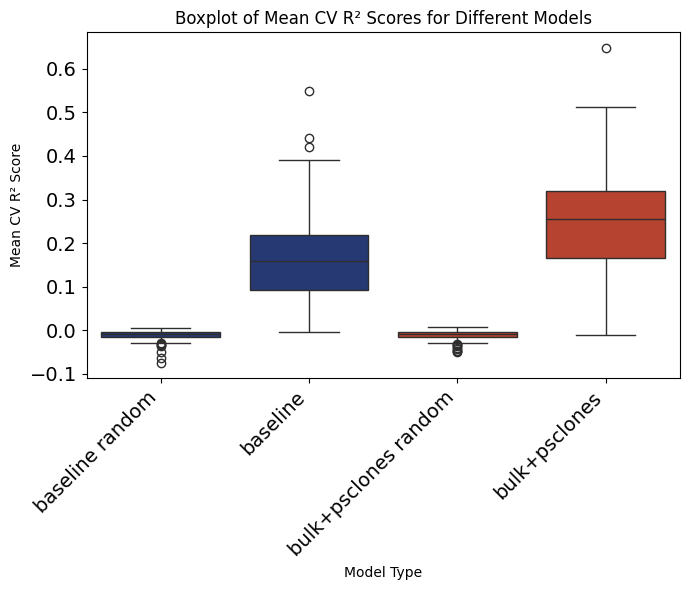

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

colors = {
    'baseline random': (0.1, 0.2, 0.5, 0.8),  # rgba: red, green, blue, alpha for 'bulk random' (transparency)
    'baseline': (0.1, 0.2, 0.5, 0.2),  # Same color as 'bulk random', but full opacity for 'bulk'
    'bulk+psclones random': (0.8, 0.2, 0.1, 0.8),  # rgba for 'bulk + psclone random'
    'bulk+psclones': (0.8, 0.2, 0.1, 0.2)  # Same color as 'bulk + psclone random' but semi-transparent for 'bulk + psclone'
}
# Reshape the DataFrame using pd.melt to long-form
df_melted = pd.melt(merged_df, id_vars=['model'], value_vars=['baseline random', 'baseline', 'bulk+psclones random', 'bulk+psclones'],
                    var_name='Category', value_name='R² Score')

# Plotting the boxplots using Seaborn
plt.figure(figsize=(7, 6))

sns.boxplot(x='Category', y='R² Score', data=df_melted, palette=colors, dodge=False)

# Add title and labels
plt.title('Boxplot of Mean CV R² Scores for Different Models')
plt.xlabel('Model Type')
plt.ylabel('Mean CV R² Score')
plt.xticks(fontsize=14,rotation=45, ha='right')  # Set font size for x-ticks
plt.yticks(fontsize=14)  # Set font size for y-ticks


# Show the plot
plt.tight_layout()
plt.show()


In [55]:
# Perform t-test to compare the two groups
import scipy.stats as stats
t_stat, p_value = stats.ttest_ind(df_base_common["mean_cv_r2_score"], df_pclone_common["mean_cv_r2_score"])
print(f"pvalue:{p_value}")

pvalue:2.377892200759505e-25
